In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import string


In [ ]:
yelp_data = pd.read_parquet('/content/drive/MyDrive/Code + Data/yelp_data.parquet')
print(yelp_data.shape)
# Balance Dataset to have equal helpful and non-helpful reviews
print(f"Original dataset size: {len(yelp_data)}")
print("0 helpful reviews:", len(yelp_data[yelp_data['helpful'] == 0]))
minority_count = len(yelp_data[yelp_data['helpful'] > 0])
print(f"helpful > 0 reviews: {minority_count}")

majority_class = yelp_data[yelp_data['helpful'] == 0]
minority_class = yelp_data[yelp_data['helpful'] > 0]

minority_count = len(minority_class)
target_majority_size = int(minority_count)  # Keep 1x as many majority class reviews; ~280k

# Downsample the majority class
downsampled_majority = majority_class.sample(n=target_majority_size, random_state=42)

balanced_data = pd.concat([downsampled_majority, minority_class])

# Shuffle
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

yelp_data = balanced_data

print(f"New dataset size: {len(yelp_data)}")
print("0 helpful reviews", len(yelp_data[yelp_data['helpful'] == 0]))
minority_count = len(yelp_data[yelp_data['helpful'] > 0])
print(f"helpful > 0 reviews: {minority_count}")


(1870042, 13)
Original dataset size: 1870042
0 helpful reviews: 1147389
helpful > 0 reviews: 722652
New dataset size: 1445304
0 helpful reviews 722652
helpful > 0 reviews: 722652


In [ ]:
# Read in the processed data for additional processing
train = pd.read_parquet('/content/drive/MyDrive/Code + Data/bn_train_data_final.parquet')
val = pd.read_parquet('/content/drive/MyDrive/Code + Data/bn_val_data_final.parquet')
test = pd.read_parquet('/content/drive/MyDrive/Code + Data/bn_test_data_final.parquet')

In [ ]:
# For the top reviewers, product rating is a significant predictor of review helpfulness
# Based on ‌A. H. Huang, K. Chen, D. C. Yen, and T. P. Tran, “A study of factors that contribute to online review helpfulness,” Computers in Human Behavior, vol. 48, pp. 17–27, Jul. 2015, doi: https://doi.org/10.1016/j.chb.2015.01.010.
# Supported hypothesis that determine who is a top reviewer: reviewer_cum_helpful # Ratio of total yes votes to total num of votes.

# Determine reviewer_cum_helpful for each reviewer
user_id_yelp_data = yelp_data.groupby('user_id')
reviewer_cum_helpfulness = user_id_yelp_data['helpful'].mean()
reviewer_cum_helpfulness.name = 'reviewer_cum_helpful'
reviewer_cum_helpfulness.sort_values(ascending=False)


,reviewer_cum_helpful
user_id,
2p7rae7haJRDBgMLiS4bbA,0.245478
MjB6Ha3rXRS4X3JsOcUiyA,0.240553
taqZAz48zB6P0OyzHl9owQ,0.197243
95GOfKoCDfeGkX2l8n8Lfw,0.181766
K74S1UK7QjAhWnkXIN0nhg,0.175204
...,...
dnM1VEzpe5EPP1vH2di10g,0.000000
dneu0_9wSuSDqvoFDuXqYQ,0.000000
dneGpk8pIVn4X8QWUC9U8Q,0.000000


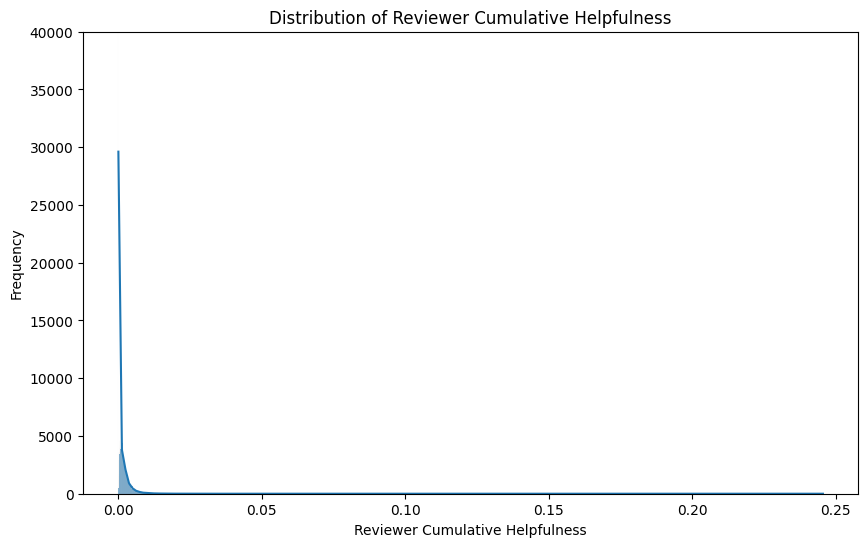

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(reviewer_cum_helpfulness, kde=True)
plt.ylim(0, 40000)  # Set the y-axis limit
plt.xlabel('Reviewer Cumulative Helpfulness')
plt.ylabel('Frequency')
plt.title('Distribution of Reviewer Cumulative Helpfulness')
plt.show()

In [ ]:
# Merge the reviewer_cum_helpful with the train, val, and test datasets
train = pd.merge(train, reviewer_cum_helpfulness, on='user_id', how='left')
val = pd.merge(val, reviewer_cum_helpfulness, on='user_id', how='left')
test = pd.merge(test, reviewer_cum_helpfulness, on='user_id', how='left')

train.head()


,review_id,user_id,business_id,stars_reviewer,useful,text,name,postal_code,stars_business,categories,...,num_words,pp_text,extractive_summary,similarity_results,weights,search_similarity,experience_similarity,categories_nature,nature,reviewer_cum_helpful
0,aBuUsiAAegcqMnNnRS4__Q,9yzin2X4I9el6s7wrFf83g,khnNWa_my3oQQghGPuILhg,5,1,Loved this place. This is a long overdue revie...,Divvy,46032,4.0,"[American (New), Tapas/Small Plates, Nightlife...",...,65,loved place. long overdue review. i've couple ...,"i've couple times (and unfortunately, photo ta...","{'Acai Bowls': None, 'Accessories': None, 'Act...","{'0': 0.0, '1': 0.0}",0.0,0.000000,"[1, 1, 1, 1, 1]",1,0.001704
1,RqUm73FUiw_5RX_jQUFQ0g,H2DNqyt2CR5a8Gv3Jisqhg,xne1l7I2166PbF59qQUxGg,3,4,I was glad that I tried this place. I happened...,Next Door American Eatery,46205,4.0,"[Bars, Burgers, Restaurants, Nightlife, Americ...",...,302,glad tried place. happened spot eatery passing...,"due yelp reviews well overall menu, decided tr...","{'Acai Bowls': None, 'Accessories': None, 'Act...","{'0': 0.0, '1': 0.0}",0.0,0.000000,"[1, 1, 1, 1, 1, 1, 1]",1,0.003759
2,HrfWlKEba1pGhn8CRfq0zA,4VfR87_EkCKBCIh9UDOC4w,4WdDY97x4GdMYtyk1KQMnw,3,0,A nice change of pace restaurant in a rich foo...,Lilly's Cafe,70130,4.5,"[Cafes, American (Traditional), Vietnamese, Re...",...,232,nice change pace restaurant rich food town. fi...,first visit nola last march 4 days eating way ...,"{'Acai Bowls': None, 'Accessories': None, 'Act...","{'0': 0.0, '1': 0.0}",0.0,0.000000,"[1, 1, 1, 1]",1,0.000900
3,2FtCv6GcNxXKYRrNkBplxA,CBD2IXxqN343egAxNoyzAg,fZ92MJ1hbEMXqwWTSwF9lA,1,2,"Please note, my friend and I only came here fo...",Gamlin Whiskey House,63108,3.5,"[Whiskey Bars, American (New), Steakhouses, Re...",...,474,"please note, friend came dinner drinks, can't ...","received check, noticed server served charged ...","{'Acai Bowls': None, 'Accessories': None, 'Act...","{'0': 0.0, '1': 0.012073632210407378}",0.0,0.012074,"[1, 1, 1, 1, 1, 1, 1]",1,0.002380
4,6QhTzU2bJTdgZjrEl3qoMw,XueJC_uWv0Lc_awL1yj2pA,7pI6lASZ4rPNPF8iX9jdoA,1,0,Two of the most annoying things I find in rest...,Ram Restaurant & Brewery,46225,3.5,"[Sports Bars, Breweries, Food, Bars, American ...",...,48,two annoying things find restaurants enter res...,two annoying things find restaurants enter res...,"{'Acai Bowls': None, 'Accessories': None, 'Act...","{'0': 0.0, '1': 0.021383343303319473}",0.0,0.021383,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",1,0.000000


In [ ]:
train.to_parquet('/content/drive/MyDrive/Code + Data/bn_train_data_final_user_cum_helpful.parquet')
val.to_parquet('/content/drive/MyDrive/Code + Data/bn_val_data_final_user_cum_helpful.parquet')
test.to_parquet('/content/drive/MyDrive/Code + Data/bn_test_data_final_user_cum_helpful.parquet')